AdaBoost 70/30


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,root_mean_squared_error
import time
import matplotlib.pyplot as plt


In [2]:
file_path = '../Data/EURUSD.xlsx'  
try:
    data = pd.read_excel(file_path)
    print(f"File '{file_path}' berhasil dimuat. Jumlah baris awal: {len(data)}")
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data.set_index('Date', inplace=True)
    
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan.")
    raise
data.head()

File '../Data/EURUSD.xlsx' berhasil dimuat. Jumlah baris awal: 1001


,Close
Date,
2022-05-15,1.03980
2022-05-16,1.04390
2022-05-17,1.05487
2022-05-18,1.04729
2022-05-19,1.05795


In [3]:
data['Close_Before_H-1'] = data['Close'].shift(1)
data['Close_Before_H-2'] = data['Close'].shift(2)
data['Close_Before_H-3'] = data['Close'].shift(3)

data.dropna(inplace=True)
print(f"Data setelah feature engineering dan pembersihan. Jumlah baris: {len(data)}")
data.head()

Data setelah feature engineering dan pembersihan. Jumlah baris: 998


,Close,Close_Before_H-1,Close_Before_H-2,Close_Before_H-3
Date,,,,
2022-05-18,1.04729,1.05487,1.04390,1.03980
2022-05-19,1.05795,1.04729,1.05487,1.04390
2022-05-20,1.05610,1.05795,1.04729,1.05487
2022-05-22,1.05689,1.05610,1.05795,1.04729
2022-05-23,1.06837,1.05689,1.05610,1.05795


In [4]:
data.shape  
data.isna().sum()

Close               0
Close_Before_H-1    0
Close_Before_H-2    0
Close_Before_H-3    0
dtype: int64

In [5]:
X = data[['Close_Before_H-1', 'Close_Before_H-2', 'Close_Before_H-3']]
y = data['Close']
train_size_70 = int(len(X) * 0.7)

X_train_70, X_test_70 = X[:train_size_70], X[train_size_70:]
y_train_70, y_test_70 = y[:train_size_70], y[train_size_70:]
print(f"Pembagian data 70/30: {len(X_train_70)} latih / {len(X_test_70)} uji")

Pembagian data 70/30: 698 latih / 300 uji


In [6]:
print("\nMemulai pelatihan model Gradient Boosting")
ada = AdaBoostRegressor(random_state=1) 
start_time = time.time()
ada.fit(X_train_70, y_train_70)
training_time = time.time() - start_time

# Detail proses pelatihan:
print("\nDetail proses pelatihan:")
print(f"Jumlah data latih: {len(X_train_70)}")
print(f"Jumlah fitur: {X_train_70.shape[1]}")
print("Fitur penting:", ada.feature_importances_)
print(f"Pelatihan Gradient Boosting selesai dalam {training_time:.4f} detik.")



Memulai pelatihan model Gradient Boosting

Detail proses pelatihan:
Jumlah data latih: 698
Jumlah fitur: 3
Fitur penting: [0.87150219 0.08734957 0.04114824]
Pelatihan Gradient Boosting selesai dalam 0.0599 detik.


In [7]:
# Melakukan prediksi pada data uji dengan model AdaBoost
y_pred_70 = ada.predict(X_test_70)
print("Hasil prediksi (5 data pertama):", y_pred_70[:5])
print("Nilai aktual (5 data pertama):", y_test_70.values[:5])

data_metrics = pd.DataFrame({
    'R2 Score': [r2_score(y_test_70, y_pred_70)],
    'RMSE': [root_mean_squared_error(y_test_70, y_pred_70)],
    'MSE': [mean_squared_error(y_test_70, y_pred_70)],
    'MAE': [mean_absolute_error(y_test_70, y_pred_70)],
    'MAPE': [mean_absolute_percentage_error(y_test_70, y_pred_70)],
    'Waktu Pelatihan (detik)': [training_time]
})

hasil_prediksi_data = X_test_70.copy()
hasil_prediksi_data['Hasil Prediksi'] = y_pred_70
hasil_prediksi_data['Aktual'] = y_test_70.values

# Menampilkan kedua tabel
display(data_metrics)
display(hasil_prediksi_data.head())

Hasil prediksi (5 data pertama): [1.09064519 1.08890729 1.09047984 1.09629049 1.09841056]
Nilai aktual (5 data pertama): [1.09127 1.09361 1.09959 1.10116 1.09723]


,R2 Score,RMSE,MSE,MAE,MAPE,Waktu Pelatihan (detik)
0,0.725153,0.022803,0.00052,0.014104,0.012423,0.059917


,Close_Before_H-1,Close_Before_H-2,Close_Before_H-3,Hasil Prediksi,Aktual
Date,,,,,
2024-08-11,1.09167,1.09149,1.09273,1.090645,1.09127
2024-08-12,1.09127,1.09167,1.09149,1.088907,1.09361
2024-08-13,1.09361,1.09127,1.09167,1.090480,1.09959
2024-08-14,1.09959,1.09361,1.09127,1.096290,1.10116
2024-08-15,1.10116,1.09959,1.09361,1.098411,1.09723


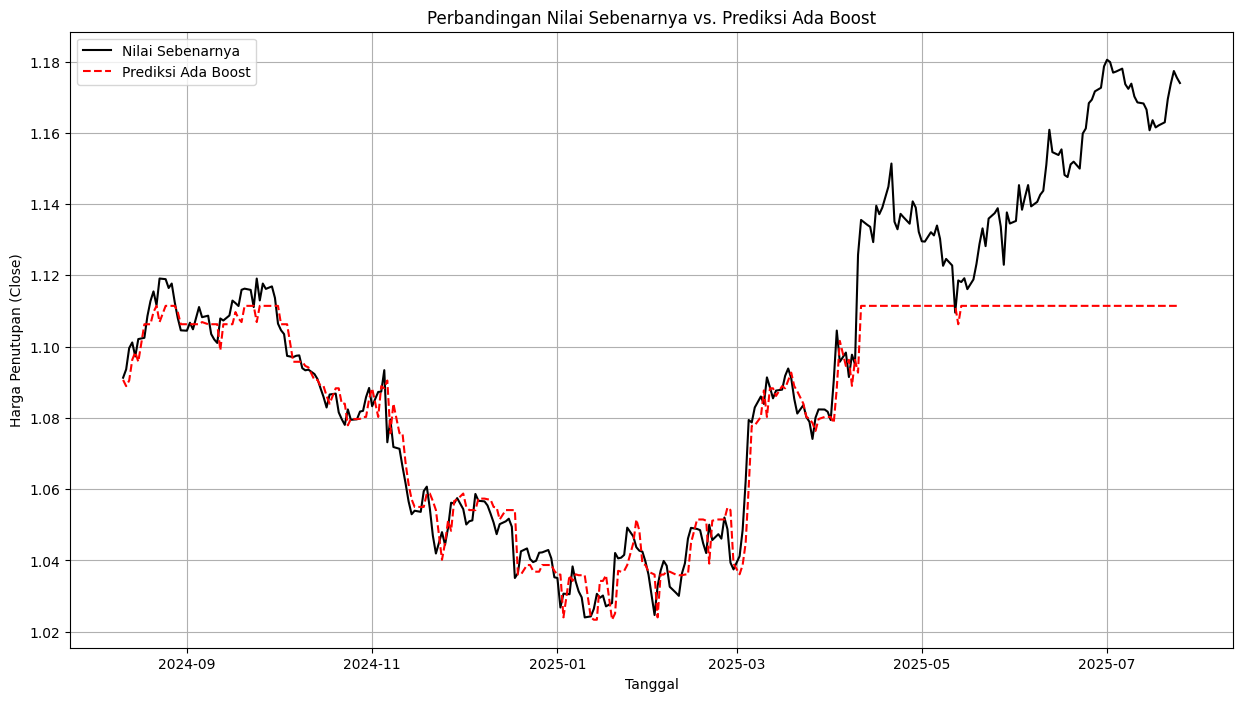

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_70.index, y_test_70.values, label='Nilai Sebenarnya', color='black')
plt.plot(y_test_70.index, y_pred_70, label='Prediksi Ada Boost', color='red', linestyle='--')
plt.title('Perbandingan Nilai Sebenarnya vs. Prediksi Ada Boost')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Close)')
plt.legend()
plt.grid(True)
plt.show()


Ada Boost 80/20

In [9]:
train_size_80 = int(len(X) * 0.8)

X_train_80, X_test_80 = X[:train_size_80], X[train_size_80:]
y_train_80, y_test_80 = y[:train_size_80], y[train_size_80:]
print(f"Pembagian data 80/20: {len(X_train_80)} latih / {len(X_test_80)} uji")


Pembagian data 80/20: 798 latih / 200 uji


In [10]:
print("\nMemulai pelatihan model Gradient Boosting")
reg = AdaBoostRegressor (random_state=1)  
start_time = time.time()  
reg.fit(X_train_80, y_train_80)  
training_time = time.time() - start_time  

# Detail proses pelatihan:
print("\nDetail proses pelatihan:")
print(f"Jumlah data latih: {len(X_train_80)}")
print(f"Jumlah fitur: {X_train_80.shape[1]}")
print("Feature Importances:", reg.feature_importances_)
print(f"Pelatihan Gradient Boosting selesai dalam {training_time:.4f} detik.")



Memulai pelatihan model Gradient Boosting

Detail proses pelatihan:
Jumlah data latih: 798
Jumlah fitur: 3
Feature Importances: [0.80534019 0.15950998 0.03514984]
Pelatihan Gradient Boosting selesai dalam 0.0484 detik.


In [11]:
y_pred_80 = reg.predict(X_test_80)

print("Hasil prediksi (5 data pertama):", y_pred_80[:5])
print("Nilai aktual (5 data pertama):", y_test_80.values[:5])

data_metrics_80 = pd.DataFrame({
    'R2 Score': [r2_score(y_test_80, y_pred_80)],
    'RMSE': [root_mean_squared_error(y_test_80, y_pred_80)],
    'MSE': [mean_squared_error(y_test_80, y_pred_80)],
    'MAE': [mean_absolute_error(y_test_80, y_pred_80)],
    'MAPE': [mean_absolute_percentage_error(y_test_80, y_pred_80)],
    'Waktu Pelatihan (detik)': [training_time]
})

hasil_prediksi_data_80 = X_test_80.copy()
hasil_prediksi_data_80['Hasil Prediksi'] = y_pred_80
hasil_prediksi_data_80['Aktual'] = y_test_80.values

# Menampilkan kedua tabel
display(data_metrics_80)
display(hasil_prediksi_data_80.head())


Hasil prediksi (5 data pertama): [1.05568439 1.05942146 1.05675719 1.05656535 1.05630277]
Nilai aktual (5 data pertama): [1.05865 1.05673 1.05656 1.05541 1.05311]


,R2 Score,RMSE,MSE,MAE,MAPE,Waktu Pelatihan (detik)
0,0.692381,0.028137,0.000792,0.019527,0.017124,0.04845


,Close_Before_H-1,Close_Before_H-2,Close_Before_H-3,Hasil Prediksi,Aktual
Date,,,,,
2024-12-05,1.05123,1.05099,1.05008,1.055684,1.05865
2024-12-06,1.05865,1.05123,1.05099,1.059421,1.05673
2024-12-08,1.05673,1.05865,1.05123,1.056757,1.05656
2024-12-09,1.05656,1.05673,1.05865,1.056565,1.05541
2024-12-10,1.05541,1.05656,1.05673,1.056303,1.05311


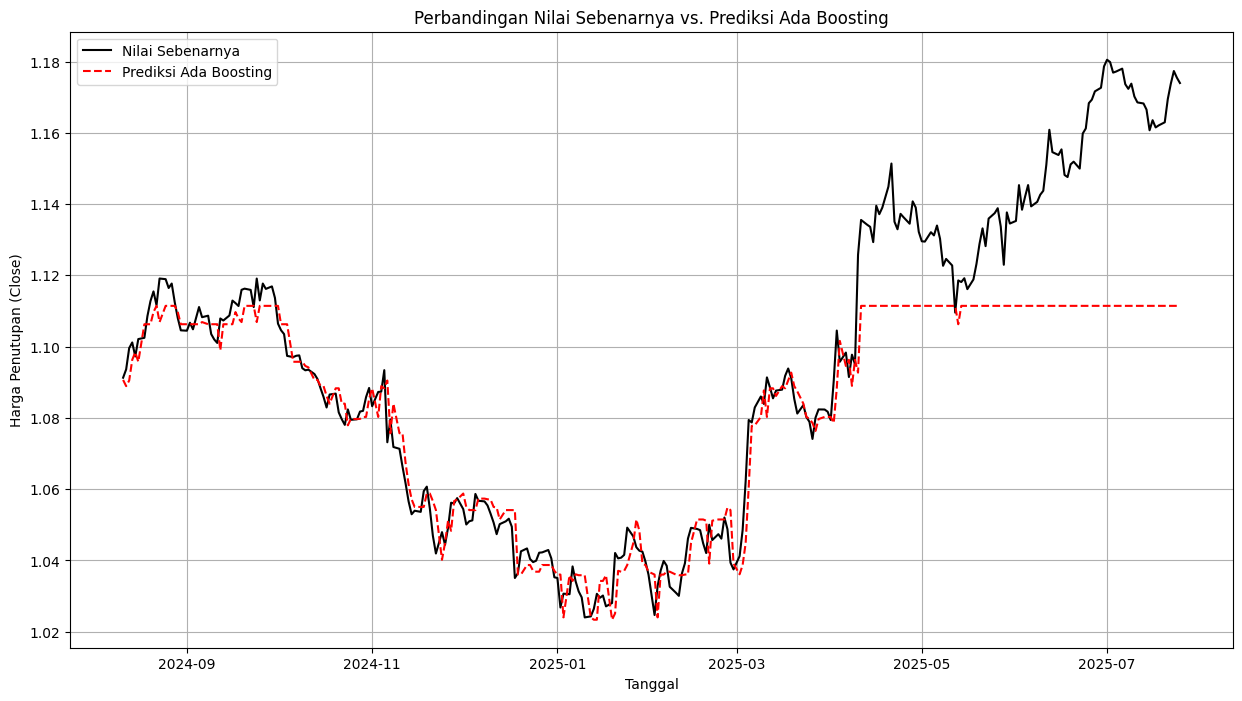

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(y_test_70.index, y_test_70.values, label='Nilai Sebenarnya', color='black')
plt.plot(y_test_70.index, y_pred_70, label='Prediksi Ada Boosting', color='red', linestyle='--')
plt.title('Perbandingan Nilai Sebenarnya vs. Prediksi Ada Boosting')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Close)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
#Melakukan prediksi pada data uji 80/20
comparison_data = pd.DataFrame({
    'Split': ['70/30', '80/20'],
    'R2 Score': [data_metrics['R2 Score'][0], data_metrics_80['R2 Score'][0]],
    'MSE': [data_metrics['MSE'][0], data_metrics_80['MSE'][0]],
    'MAE': [data_metrics['MAE'][0], data_metrics_80['MAE'][0]],
    'MAPE': [data_metrics['MAPE'][0], data_metrics_80['MAPE'][0]],
    'Waktu Pelatihan (detik)': [data_metrics['Waktu Pelatihan (detik)'][0], data_metrics_80['Waktu Pelatihan (detik)'][0]]
})

display(comparison_data)

#Menampilkan split dengan akurasi (R2 Score) tertinggi
best_split = comparison_data.loc[comparison_data['R2 Score'].idxmax()]
print(f"Split dengan akurasi (R2 Score) tertinggi: {best_split['Split']} (R2 Score: {best_split['R2 Score']:.5f})")

,Split,R2 Score,MSE,MAE,MAPE,Waktu Pelatihan (detik)
0,70/30,0.725153,0.000520,0.014104,0.012423,0.059917
1,80/20,0.692381,0.000792,0.019527,0.017124,0.048450


Split dengan akurasi (R2 Score) tertinggi: 70/30 (R2 Score: 0.72515)
